
Pierwsza część kodu dotycząca oczyszczeniu danych znajduje się w pliku 1_EDA.ipynb, w którym zostały obrobione dane do budowy modelu klasyfukacji binarnej. Dane są do pobrania z https://www.kaggle.com/c/tabular-playground-series-mar-2021/data

In [1]:
import pandas as pd
import numpy as np
import os 

data_path = r"E:\page_ds\overestimating_features"
X = pd.read_csv(os.path.join(data_path, "x_train.csv"))
y = pd.read_csv(os.path.join(data_path, "y_train.csv"))



Accuracy for validation set: 0.8416
Accuracy for train set: 0.9247
Wartość parametru Gini na zbiorze walidacyjnym to: 0.7569
Wartość parametru Gini na zbiorze treningowym to: 0.9417

ROC Curve

Confusion Matrix


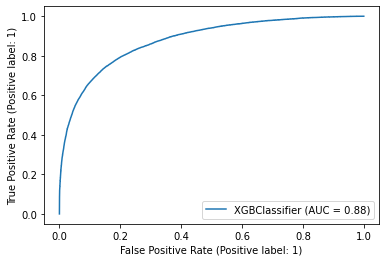

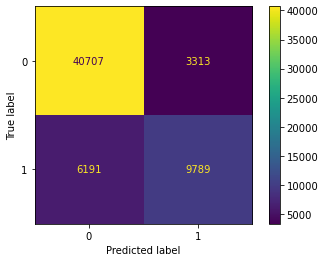

In [2]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score # dane są nisko niezbalansowane przez co powinniśmy rozpatrzyć losowanie warstwowe
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

# dzielimy nasz zbiór na treningowy oraz testowy. Poza tym pamiętajmy, że mamy do dyspozycji zbiór walidacyjny około 200k rekordów
# ponieważ wybór proporcji próbki na uczącą i walidacyjną może wpłynąć na jakość modelu, powinniśmy rozważyć wrzucenie tego 
# parametru jako elementu optymalizacji hiperparametrów

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state=128262)

    
# inicjalizujemy model 
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            booster="gbtree",
                            reg_lambda = 0.451065801218468,
                            alpha=0.6902857337758832,
                            max_depth=9,
                            eta=0.40371759686544195,
                            gamma=2.542658350556566e-08,
                            grow_policy="lossguide",
                           # sample_type="weighted",
                           #normalize_type="forest",
                            #rate_drop=3.3165167625838494e-07,
                            #skip_drop=0.0003657525314966573
                            )

    
# uczymy model, korzystamy z API sklearn
xgb_clf.fit(X_train, y_train)

# przeliczamy skoringi na zbiorze testowym aby sprawdzić jakość modelu w rozumieniu interesujących mnie miar

y_hat = xgb_clf.predict(X_test)

auc_val = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
auc_train = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])

print("Accuracy for validation set: {0:.4f}".format(accuracy_score(y_test, y_hat)))
print("Accuracy for train set: {0:.4f}".format(accuracy_score(y_train, xgb_clf.predict(X_train))))

print("Wartość parametru Gini na zbiorze walidacyjnym to: {0:.4f}".format(2*auc_val-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze treningowym to: {0:.4f}".format(2*auc_train-1)) # Gini = 2*AUC-1

print("\nROC Curve")
print(RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test))

print("\nConfusion Matrix")
#print(plot_confusion_matrix(xgb_clf, X_test, y_test))
cm = confusion_matrix(y_test, y_hat, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
print(disp.plot())
plt.show()